In [49]:
import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

dataset = pd.read_csv('appdata10.csv')

In [50]:
dataset.describe() # Distribution of Numerical Variables

,user,dayofweek,age,numscreens,minigame,used_premium_feature,enrolled,liked
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,186889.729900,3.029860,31.72436,21.095900,0.107820,0.172020,0.621480,0.165000
std,107768.520361,2.031997,10.80331,15.728812,0.310156,0.377402,0.485023,0.371184
min,13.000000,0.000000,16.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,93526.750000,1.000000,24.00000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,187193.500000,3.000000,29.00000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,279984.250000,5.000000,37.00000,28.000000,0.000000,0.000000,1.000000,0.000000
max,373662.000000,6.000000,101.00000,325.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
dataset.head(2) # Viewing the Data

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0


In [52]:
# First set of Feature cleaning
dataset["hour"] = dataset.hour.str.slice(1, 3).astype(int)

### Plotting
dataset2 = dataset.copy().drop(columns = ['user', 'screen_list', 'enrolled_date',
                                           'first_open', 'enrolled'])
dataset2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


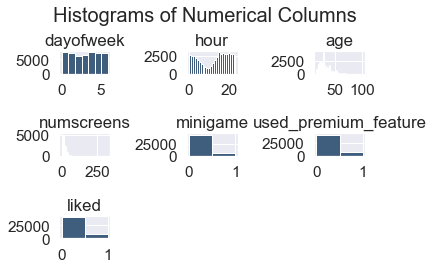

In [53]:
## Histograms
plt.suptitle('Histograms of Numerical Columns', fontsize=20)
for i in range(1, dataset2.shape[1] + 1):
    plt.subplot(3, 3, i)
    f = plt.gca()
#    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i - 1])

    vals = np.size(dataset2.iloc[:, i - 1].unique())
    
    plt.hist(dataset2.iloc[:, i - 1], bins=vals, color='#3F5D7D')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

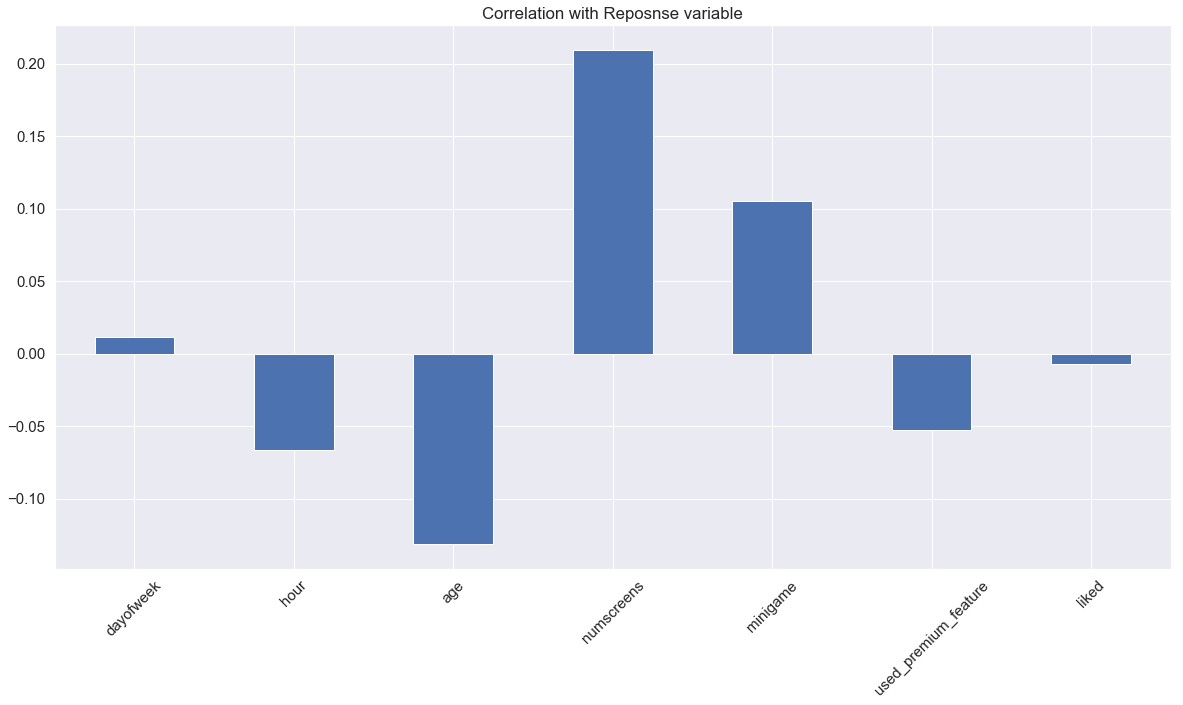

In [54]:
## Correlation with Response Variable
dataset2.corrwith(dataset.enrolled).plot.bar(figsize=(20,10),
                  title = 'Correlation with Reposnse variable',
                  fontsize = 15, rot = 45,
                  grid = True)


In [55]:
## Correlation Matrix
sn.set(style="white", font_scale=2)
# Compute the correlation matrix
corr = dataset2.corr()

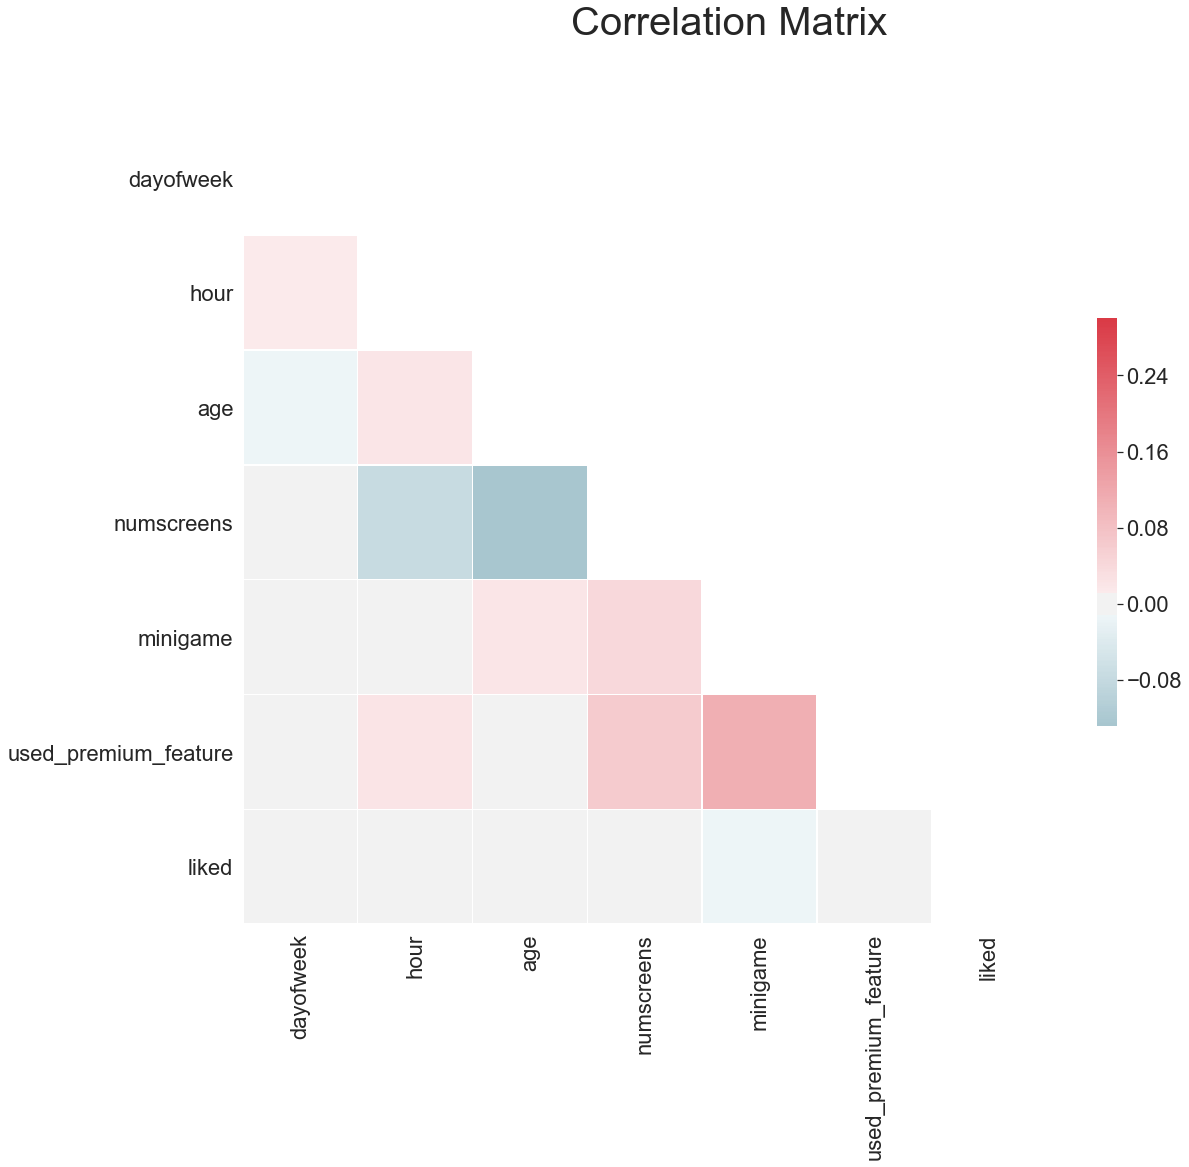

In [56]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))
f.suptitle("Correlation Matrix", fontsize = 40)

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

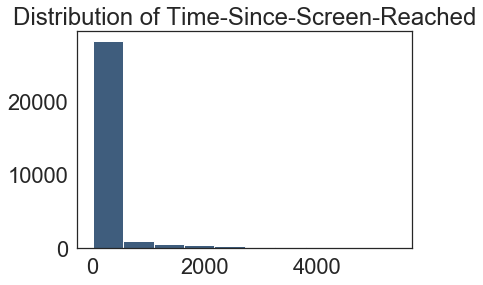

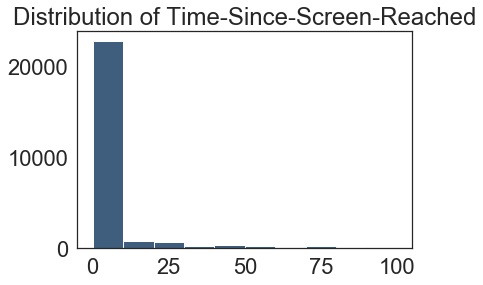

In [57]:
# Formatting Date Columns
dataset.dtypes
dataset["first_open"] = [parser.parse(row_date) for row_date in dataset["first_open"]]
dataset["enrolled_date"] = [parser.parse(row_date) if isinstance(row_date, str) else row_date for row_date in dataset["enrolled_date"]]
dataset.dtypes

# Selecting Time For Response
dataset["difference"] = (dataset.enrolled_date-dataset.first_open).astype('timedelta64[h]')
response_hist = plt.hist(dataset["difference"].dropna(), color='#3F5D7D')
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

plt.hist(dataset["difference"].dropna(), color='#3F5D7D', range = [0, 100])
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

dataset.loc[dataset.difference > 48, 'enrolled'] = 0
dataset = dataset.drop(columns=['enrolled_date', 'difference', 'first_open'])

In [58]:
## Formatting the screen_list Field

# Load Top Screens
top_screens = pd.read_csv('top_screens.csv').top_screens.values
top_screens

# Mapping Screens to Fields
dataset["screen_list"] = dataset.screen_list.astype(str) + ','

for sc in top_screens:
    dataset[sc] = dataset.screen_list.str.contains(sc).astype(int)
    dataset['screen_list'] = dataset.screen_list.str.replace(sc+",", "")

dataset['Other'] = dataset.screen_list.str.count(",")
dataset = dataset.drop(columns=['screen_list'])

In [59]:
# Funnels
savings_screens = ["Saving1",
                    "Saving2",
                    "Saving2Amount",
                    "Saving4",
                    "Saving5",
                    "Saving6",
                    "Saving7",
                    "Saving8",
                    "Saving9",
                    "Saving10"]
dataset["SavingCount"] = dataset[savings_screens].sum(axis=1)
dataset = dataset.drop(columns=savings_screens)

cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
dataset["CMCount"] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(columns=cm_screens)

cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
dataset["CCCount"] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(columns=cc_screens)

loan_screens = ["Loan",
               "Loan2",
               "Loan3",
               "Loan4"]
dataset["LoansCount"] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(columns=loan_screens)

#### Saving Results ####
dataset.head()
dataset.describe()
dataset.columns

Index(['user', 'dayofweek', 'hour', 'age', 'numscreens', 'minigame',
       'used_premium_feature', 'enrolled', 'liked', 'location', 'Institutions',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth', 'ProfilePage',
       'VerifyCountry', 'Cycle', 'idscreen', 'Splash', 'RewardsContainer',
       'EditProfile', 'Finances', 'Alerts', 'Leaderboard', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'ProfileEducationMajor', 'Rewards', 'AccountView', 'VerifyAnnualIncome',
       'VerifyIncomeType', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'ResendToken',
       'TransactionList', 'NetworkFailure', 'ListPicker', 'Other',
       'SavingCount', 'CMCount', 'CCCount', 'LoansCount'],
      dtype='object')

In [60]:
dataset.to_csv('new_appdata10.csv', index = False)

In [61]:
dataset = pd.read_csv('new_appdata10.csv')


#### Data Pre-Processing ####

# Splitting Independent and Response Variables
response = dataset["enrolled"]
dataset = dataset.drop(columns="enrolled")

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, response,
                                                    test_size = 0.2,
                                                    random_state = 0
                                                   )

In [62]:
# Removing Identifiers
train_identity = X_train['user']
X_train = X_train.drop(columns = ['user'])
test_identity = X_test['user']
X_test = X_test.drop(columns = ['user'])

In [63]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

In [64]:
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

C:\Users\codehax41\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\codehax41\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\codehax41\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [65]:
#### Model Building ####


# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0, penalty = 'l1')
classifier.fit(X_train, y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test)

# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

C:\Users\codehax41\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7681

In [66]:
precision_score(y_test, y_pred) # tp / (tp + fp)

0.7618952017667135

In [67]:
recall_score(y_test, y_pred) # tp / (tp + fn)

0.7700892857142857

In [68]:
f1_score(y_test, y_pred)

0.7659703300030276

Test Data Accuracy: 0.7681


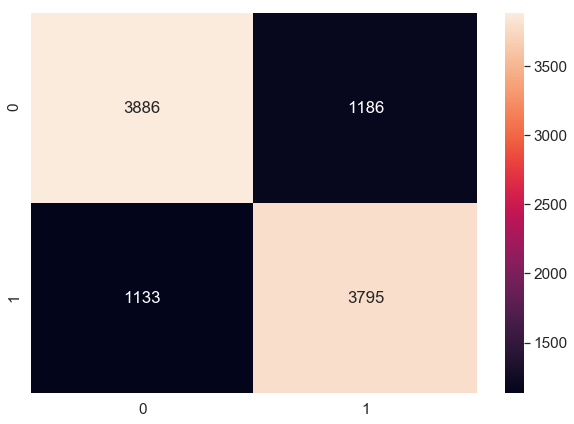

In [69]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [70]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

C:\Users\codehax41\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\codehax41\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\codehax41\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\codehax41\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\codehax41\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a

SVM Accuracy: 0.767 (+/- 0.010)


In [71]:
# Analyzing Coefficients
pd.concat([pd.DataFrame(dataset.drop(columns = 'user').columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,dayofweek,0.032574
1,hour,-0.003600
2,age,-0.149688
3,numscreens,-0.130597
4,minigame,-0.026462
5,used_premium_feature,-0.065907
6,liked,0.010695
7,location,-0.028331
8,Institutions,-0.062195
9,VerifyPhone,0.650341


In [72]:
### Model Tuning ####

## Grid Search (Round 1)
from sklearn.model_selection import GridSearchCV

# Select Regularization Method
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Combine Parameters
parameters = dict(C=C, penalty=penalty)

In [73]:
import time
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = "accuracy",
                           cv = 10,
                           n_jobs = -1)
t0 = time.time()
grid_search = grid_search.fit(X_train, y_train)
t1 = time.time()
print("Took %0.2f seconds" % (t1 - t0))

rf_best_accuracy = grid_search.best_score_
rf_best_parameters = grid_search.best_params_
rf_best_accuracy, rf_best_parameters
grid_search.best_score_


#### End of Model ####

C:\Users\codehax41\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Took 60.58 seconds


0.7674

In [75]:
# Formatting Final Results
final_results = pd.concat([y_test, test_identity], axis = 1).dropna()
final_results['predicted_reach'] = y_pred
final_results = final_results[['user', 'enrolled', 'predicted_reach']].reset_index(drop=True)

In [76]:
final_results

,user,enrolled,predicted_reach
0,239786,1,1
1,279644,1,1
2,98290,0,0
3,170150,1,1
4,237568,1,1
5,65042,1,0
6,207226,1,1
7,363062,0,0
8,152296,1,1
9,64484,0,0
